In [31]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

sns.set(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})
pd.set_option("display.max_columns", 200)
RNG = 42

In [32]:
raw = pd.read_csv('Fashion_Retail_Sales.csv')
print("Raw shape:", raw.shape)
raw.head()

Raw shape: (3400, 6)


,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,05-02-2023,NaN,Credit Card
1,4115,Tunic,2456.0,11-07-2023,2.0,Credit Card
2,4019,Tank Top,2102.0,23-03-2023,4.1,Cash
3,4097,Leggings,3126.0,15-03-2023,3.2,Cash
4,3997,Wallet,3003.0,27-11-2022,4.7,Cash


In [33]:
# Parse dates (your data looked day-first like 23-03-2023)
raw["Date Purchase"] = pd.to_datetime(raw["Date Purchase"], errors="coerce", dayfirst=True)
raw = raw.dropna(subset=["Date Purchase"]).copy()

# Month start for grouping
raw["month_start"] = raw["Date Purchase"].dt.to_period("M").dt.to_timestamp()

# Choose a reference payment method for share (fallback to top method if "Credit Card" absent)
top_method = raw["Payment Method"].mode().iat[0] if not raw["Payment Method"].mode().empty else None
ref_method = "Credit Card" if "Credit Card" in raw["Payment Method"].unique() else top_method

# Aggregate to item × month
panel = (
    raw.groupby(["Item Purchased","month_start"], as_index=False)
       .agg(
           total_sales=("Purchase Amount (USD)", "sum"),
           orders=("Purchase Amount (USD)", "size"),
           avg_rating=("Review Rating", "mean"),
           pay_ref_share=("Payment Method", lambda s: (s==ref_method).mean() if ref_method else 0.0)
       )
)

# Calendar features
panel["year"]  = panel["month_start"].dt.year
panel["month"] = panel["month_start"].dt.month
panel["ym_idx"] = (panel["year"] - panel["year"].min())*12 + panel["month"]  # simple trend index

panel.sort_values(["Item Purchased","month_start"], inplace=True)
panel.head()


,Item Purchased,month_start,total_sales,orders,avg_rating,pay_ref_share,year,month,ym_idx
0,Backpack,2022-10-01,803.0,9,3.033333,0.333333,2022,10,10
1,Backpack,2022-11-01,343.0,3,2.666667,0.666667,2022,11,11
2,Backpack,2022-12-01,486.0,6,2.920000,0.833333,2022,12,12
3,Backpack,2023-01-01,655.0,10,2.930000,0.500000,2023,1,13
4,Backpack,2023-02-01,954.0,9,3.400000,0.555556,2023,2,14


In [34]:
g = panel.groupby("Item Purchased", sort=False)

# 1-step lag of target and orders
panel["total_sales_lag1"] = g["total_sales"].shift(1)
panel["orders_lag1"]      = g["orders"].shift(1)

# Rolling means (use only past info: shift before rolling)
panel["total_sales_roll3"] = g["total_sales"].shift(1).rolling(3).mean()
panel["orders_roll3"]      = g["orders"].shift(1).rolling(3).mean()

# Drop first rows with missing lags/rolls (can't train on them)
panel = panel.dropna(subset=["total_sales_lag1","orders_lag1","total_sales_roll3","orders_roll3"]).reset_index(drop=True)
print("Panel shape after lags/rolls:", panel.shape)
panel.head()


Panel shape after lags/rolls: (453, 13)


,Item Purchased,month_start,total_sales,orders,avg_rating,pay_ref_share,year,month,ym_idx,total_sales_lag1,orders_lag1,total_sales_roll3,orders_roll3
0,Backpack,2023-01-01,655.0,10,2.930000,0.500000,2023,1,13,486.0,6.0,544.000000,6.000000
1,Backpack,2023-02-01,954.0,9,3.400000,0.555556,2023,2,14,655.0,10.0,494.666667,6.333333
2,Backpack,2023-03-01,477.0,4,2.375000,0.750000,2023,3,15,954.0,9.0,698.333333,8.333333
3,Backpack,2023-04-01,486.0,6,3.640000,0.666667,2023,4,16,477.0,4.0,695.333333,7.666667
4,Backpack,2023-05-01,563.0,7,2.628571,0.428571,2023,5,17,486.0,6.0,639.000000,6.333333


In [35]:
TARGET = "total_sales"

num_cols = [
    "orders","avg_rating","pay_ref_share","ym_idx",
    "total_sales_lag1","total_sales_roll3",
    "orders_lag1","orders_roll3"
]
cat_cols = ["Item Purchased","year","month"]

X = panel[num_cols + cat_cols].copy()
y = panel[TARGET].astype(float)

# split by month, not randomly
unique_months = panel["month_start"].sort_values().unique()
cut = int(0.8 * len(unique_months))
cutoff_month = unique_months[cut]

mask = panel["month_start"] < cutoff_month
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (399, 11) Test: (54, 11)


In [36]:
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("te", TargetEncoder(smoothing=0.3, handle_unknown="value", handle_missing="value"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

def ttr(model):
    return TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)

model = HistGradientBoostingRegressor(
    max_depth=4, learning_rate=0.06, max_iter=600, random_state=RNG
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", ttr(model))
])

In [37]:
# Define pipes and models outside the function as they don't change per call
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("te", TargetEncoder(smoothing=0.3, handle_unknown="value", handle_missing="value"))
])

def ttr(model):
    return TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)

model = HistGradientBoostingRegressor(
    max_depth=4, learning_rate=0.06, max_iter=600, random_state=RNG
)

# Define the ColumnTransformer using the global num_cols and cat_cols
preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Define pipelines using the defined preprocess and model
pipelines = {"HistGradientBoostingRegressor": Pipeline([("prep", preprocess), ("model", ttr(model))])}


def eval_pipe(name, pipe, X_tr, y_tr, X_te, y_te):
    # Drop rows with NaN in y_tr
    not_nan_indices_tr = y_tr.dropna().index
    X_tr_cleaned = X_tr.loc[not_nan_indices_tr]
    y_tr_cleaned = y_tr.loc[not_nan_indices_tr]

    # Fit the pipeline on the cleaned training data
    # Recreate the pipeline here to ensure the ColumnTransformer is fresh
    current_pipe = Pipeline([("prep", preprocess), ("model", ttr(model))])
    current_pipe.fit(X_tr_cleaned, y_tr_cleaned)
    pred_tr = current_pipe.predict(X_tr_cleaned)

    # Drop rows with NaN in y_te for evaluation
    not_nan_indices_te = y_te.dropna().index
    X_te_cleaned = X_te.loc[not_nan_indices_te]
    y_te_cleaned = y_te.loc[not_nan_indices_te]
    pred_te = current_pipe.predict(X_te_cleaned)


    def sc(y_true, y_pred):
        return (
            mean_absolute_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred)),
            r2_score(y_true, y_pred)
        )
    mae_tr, rmse_tr, r2_tr = sc(y_tr_cleaned, pred_tr)
    mae, rmse, r2 = sc(y_te_cleaned, pred_te)

    # TimeSeries CV on train - compute RMSE correctly (no double-negation)
    tscv = TimeSeriesSplit(n_splits=5)
    cv_mse = -cross_val_score(
        current_pipe,
        X_tr_cleaned,
        y_tr_cleaned,
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    ).mean()
    cv_rmse = float(np.sqrt(cv_mse))

    return {
        "MAE": round(mae, 3), "RMSE": round(rmse, 3), "R2": round(r2, 3),
        "MAE_train": round(mae_tr, 3), "RMSE_train": round(rmse_tr, 3), "R2_train": round(r2_tr, 3),
        "CV_RMSE_train": round(cv_rmse, 3)
    }, current_pipe

metrics, fitted = {}, {}
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    # Pass the original X_train and y_train to eval_pipe, cleaning is done inside
    m, p = eval_pipe(name, pipe, X_train, y_train, X_test, y_test)
    metrics[name] = m
    fitted[name] = p

print("\nMetrics:")
print(json.dumps(metrics, indent=2))
with open("fashion_metrics.json","w") as f: json.dump(metrics, f, indent=2)
print("Wrote metrics.json")

Training HistGradientBoostingRegressor...

Metrics:
{
  "HistGradientBoostingRegressor": {
    "MAE": 231.034,
    "RMSE": 533.949,
    "R2": 0.033,
    "MAE_train": 235.052,
    "RMSE_train": 598.248,
    "R2_train": 0.575,
    "CV_RMSE_train": 985.152
  }
}
Wrote metrics.json


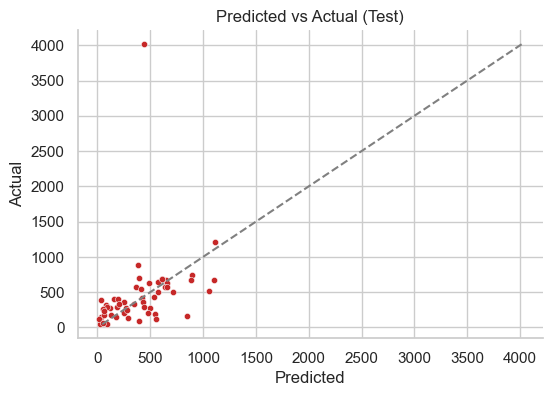

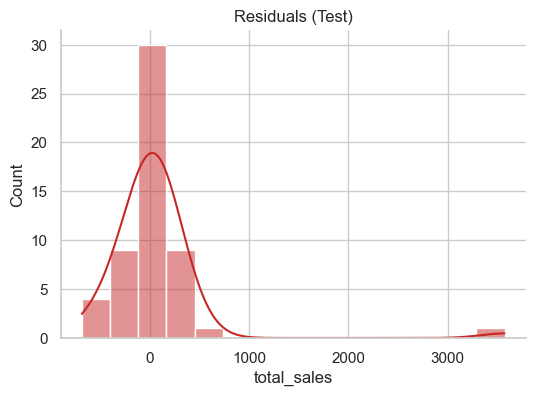

In [38]:
# Use the fitted pipeline to generate predictions for plotting
not_nan_indices_te = y_test.dropna().index
X_te_cleaned = X_test.loc[not_nan_indices_te]
y_te_cleaned = y_test.loc[not_nan_indices_te]

y_pred = fitted[list(fitted.keys())[0]].predict(X_te_cleaned)

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=y_te_cleaned, s=20, color="#C62828")
plt.plot([y_te_cleaned.min(), y_te_cleaned.max()], [y_te_cleaned.min(), y_te_cleaned.max()], "--", color="gray")
plt.title("Predicted vs Actual (Test)"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

resid = y_te_cleaned - y_pred
plt.figure(figsize=(6,4))
sns.histplot(resid, kde=True, color="#C62828")
plt.title("Residuals (Test)"); plt.show()


In [39]:
# Persist the fitted components from the best pipeline
best_name = list(fitted.keys())[0]
best_pipe = fitted[best_name]

# Save underlying regressor + preprocess from the fitted pipeline
joblib.dump(best_pipe.named_steps["model"].regressor_, "fashion_monthly_best_model.pkl")
joblib.dump(best_pipe.named_steps["prep"],               "fashion_monthly_preprocess.pkl")

# For a UI or batch inference
cat_choices = {}
for c in cat_cols:
    top = X_train[c].astype(str).dropna().value_counts().head(50).index.tolist()
    cat_choices[c] = sorted(top)

cfg = {
    "TARGET_COL": TARGET,
    "NUMERIC_COLS": num_cols,
    "CATEGORICAL_COLS": cat_cols,
    "TEXT_COL": None,
    "CATEGORICAL_CHOICES": cat_choices
}
joblib.dump(cfg, "fashion_monthly_config.pkl")
print("Saved fashion_monthly_best_model.pkl, fashion_monthly_preprocess.pkl, fashion_monthly_config.pkl")

Saved fashion_monthly_best_model.pkl, fashion_monthly_preprocess.pkl, fashion_monthly_config.pkl


In [40]:
def forecast_next_month_per_item(panel_df, fitted_pipe):
    """Return dataframe with predicted total_sales for next month per item."""
    last_month = panel_df["month_start"].max()
    next_month = (last_month + pd.offsets.MonthBegin(1)).to_period("M").start_time

    g = panel_df.groupby("Item Purchased", sort=False)

    # Build rows for each item at next_month
    rows = []
    for item, grp in g:
        grp = grp.sort_values("month_start")
        if grp.empty:
            continue

        last = grp.iloc[-1]
        # Build required features
        orders             = last["orders"]  # naive: carry last; or use same-season mean if you prefer
        avg_rating         = grp["avg_rating"].iloc[-3:].mean() if len(grp)>=3 else grp["avg_rating"].mean()
        pay_ref_share      = grp["pay_ref_share"].iloc[-3:].mean() if len(grp)>=3 else grp["pay_ref_share"].mean()
        total_sales_lag1   = last["total_sales"]
        total_sales_roll3  = grp["total_sales"].iloc[-3:].mean() if len(grp)>=3 else grp["total_sales"].mean()
        orders_lag1        = last["orders"]
        orders_roll3       = grp["orders"].iloc[-3:].mean() if len(grp)>=3 else grp["orders"].mean()
        year               = next_month.year
        month              = next_month.month
        ym_idx             = (year - panel_df["year"].min())*12 + month

        rows.append({
            "Item Purchased": item,
            "month_start": next_month,
            "orders": orders,
            "avg_rating": avg_rating,
            "pay_ref_share": pay_ref_share,
            "ym_idx": ym_idx,
            "total_sales_lag1": total_sales_lag1,
            "total_sales_roll3": total_sales_roll3,
            "orders_lag1": orders_lag1,
            "orders_roll3": orders_roll3,
            "year": year,
            "month": month
        })

    fut = pd.DataFrame(rows)
    X_fut = fut[["orders","avg_rating","pay_ref_share","ym_idx",
                 "total_sales_lag1","total_sales_roll3","orders_lag1","orders_roll3",
                 "Item Purchased","year","month"]]

    y_fut = fitted_pipe.predict(X_fut)
    fut["pred_total_sales"] = y_fut
    return fut.sort_values("pred_total_sales", ascending=False)

# Use the fitted best pipeline for forecasting
next_month_preds = forecast_next_month_per_item(panel, best_pipe)
next_month_preds.head(10)


,Item Purchased,month_start,orders,avg_rating,pay_ref_share,ym_idx,total_sales_lag1,total_sales_roll3,orders_lag1,orders_roll3,year,month,pred_total_sales
42,Tank Top,2023-11-01,8,3.538333,0.550000,11,469.0,342.000000,8,5.666667,2023,11,1976.157287
20,Leggings,2023-11-01,9,2.801852,0.592593,11,680.0,580.000000,9,6.333333,2023,11,995.444910
30,Sandals,2023-11-01,6,3.149444,0.505556,11,367.0,351.666667,6,5.000000,2023,11,958.890914
41,T-shirt,2023-11-01,8,2.716667,0.559524,11,579.0,566.000000,8,7.000000,2023,11,940.318915
35,Sneakers,2023-11-01,10,3.078889,0.702381,11,1212.0,738.000000,10,7.000000,2023,11,813.849770
36,Socks,2023-11-01,6,3.015476,0.601852,11,297.0,490.333333,6,7.666667,2023,11,751.654431
25,Pants,2023-11-01,6,2.858889,0.466667,11,209.0,353.333333,6,7.333333,2023,11,748.163848
2,Blazer,2023-11-01,4,3.600000,0.125000,11,292.0,339.666667,4,4.666667,2023,11,690.788310
22,Onesie,2023-11-01,7,2.708571,0.574603,11,519.0,512.666667,7,6.000000,2023,11,669.790448
21,Loafers,2023-11-01,7,3.445079,0.514286,11,741.0,633.000000,7,6.333333,2023,11,649.357390
